In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
def transform_features(df):
    df.drop(['SERV_AREA_ID','ApptDate','har','DEPARTMENT_NAME',
            'DEPARTMENT_ID','Smoker','Hispanic','Language','pat_id','DepSpecialty'],axis=1,inplace=True)
    df = df[df.Status != 'Scheduled']
    df = df[df.LeadDays > 0]
    df = simplify_lead(df)
    df = simplify_bmi(df)
    df = simplify_ages(df)
    df.Religion = df.Religion.fillna('Unknown')
    df.Race = df.Race.fillna('Patient Declined')
    df.Status = df.Status.map({'Completed':0,'No Show':1})
    df.rename(columns={'Status':'NoShow'},inplace=True)
    return df

def simplify_lead(df):
    
    bins = (0,9,22,52,10000)
    group_names = ['1_Quartile','2_Quartile','3_Quartile','4_Quartile']
    categories = pd.cut(df.LeadDays,bins,labels=group_names)
    df.LeadDays = categories
    return df

def simplify_bmi(df):
    df.BMI = df.BMI.fillna(-1)
    bins = (-10,0,23,28,35,10000)
    group_names = ['Unknown','1_Quartile','2_Quartile','3_Quartile','4_Quartile']
    categories = pd.cut(df.BMI,bins,labels=group_names)
    df.BMI = categories
    return df

def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

df = pd.read_csv('FMtest.csv')
df = transform_features(df)
df = df[df['BMI'].notnull()]

In [6]:
df.head()

,NoShowCount,NoShow,ApptHour,DayOfWeek,ApptMonth,PCP,Referral,LeadDays,csn,ApptChanged,isReschedule,Age,Sex,Race,Married,Religion,BMI
0,0,0,9,Tuesday,10,0,0,4_Quartile,6.000390e+11,1,0,Baby,1,Black or African American,0,Christian,1_Quartile
1,0,0,14,Monday,10,0,1,4_Quartile,6.000420e+11,0,0,Young Adult,2,White or Caucasian,0,Christian,4_Quartile
2,0,1,8,Monday,10,0,0,4_Quartile,6.000430e+11,0,0,Adult,1,Black or African American,1,Baptist,3_Quartile
3,0,0,13,Friday,10,1,1,4_Quartile,6.000430e+11,0,0,Adult,1,Black or African American,1,Baptist,4_Quartile
4,2,1,8,Monday,10,0,1,4_Quartile,6.000450e+11,0,0,Adult,2,Black or African American,0,Methodist,Unknown


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31191 entries, 0 to 34278
Data columns (total 17 columns):
NoShowCount     31191 non-null int64
NoShow          31191 non-null int64
ApptHour        31191 non-null int64
DayOfWeek       31191 non-null object
ApptMonth       31191 non-null int64
PCP             31191 non-null int64
Referral        31191 non-null int64
LeadDays        31191 non-null category
csn             31191 non-null float64
ApptChanged     31191 non-null int64
isReschedule    31191 non-null int64
Age             31191 non-null category
Sex             31191 non-null int64
Race            31191 non-null object
Married         31191 non-null int64
Religion        31191 non-null object
BMI             31191 non-null category
dtypes: category(3), float64(1), int64(10), object(3)
memory usage: 3.7+ MB


In [42]:
def split_set(df):
    msk = np.random.rand(len(df)) < 0.8
    train = df[msk]
    test = df[~msk]
    return train, test
    
#train, test = split_set(df)

In [8]:
from sklearn import preprocessing
def encode_features(_df):#df_train, df_test):
    features = ['DayOfWeek','LeadDays','Age','Race',
                'Religion','BMI']
    #df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        #le = le.fit(df_combined[feature])
        le = le.fit(_df[feature])
        _df[feature] = le.transform(_df[feature])
        #df_test[feature] = le.transform(df_test[feature])
    return _df

#train, test = encode_features(train, test)
df = encode_features(df)
df.head()

,NoShowCount,NoShow,ApptHour,DayOfWeek,ApptMonth,PCP,Referral,LeadDays,csn,ApptChanged,isReschedule,Age,Sex,Race,Married,Religion,BMI
0,0,0,9,3,10,0,0,3,6.000390e+11,1,0,1,1,2,0,4,0
1,0,0,14,1,10,0,1,3,6.000420e+11,0,0,7,2,6,0,4,3
2,0,1,8,1,10,0,0,3,6.000430e+11,0,0,0,1,2,1,1,2
3,0,0,13,0,10,1,1,3,6.000430e+11,0,0,0,1,2,1,1,3
4,2,1,8,1,10,0,1,3,6.000450e+11,0,0,0,2,2,0,13,4


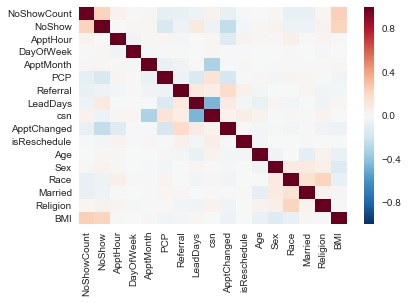

In [9]:
sns.heatmap(df.corr())

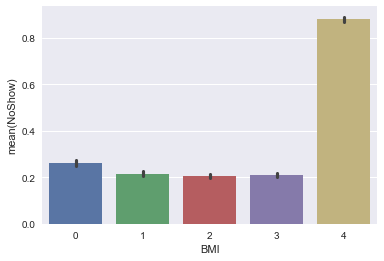

In [11]:
sns.barplot(x='BMI',y='NoShow',data=df)

In [111]:
df[df['BMI']==4]['NoShow'].value_counts()

1    2838
0     384
Name: NoShow, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split

x_all = df.drop(['NoShow','csn'],axis=1)
y_all = df['NoShow']

num_test = 0.20

x_train, x_test, y_train, y_test = train_test_split(x_all, y_all,
test_size = num_test, random_state = 23)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, parameters, scoring = acc_scorer)
grid_obj = grid_obj.fit(x_train, y_train)

clf = grid_obj.best_estimator_

clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=6, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [14]:
prob = clf.predict_proba(x_test)

In [13]:
predictions = clf.predict(x_test)
print(accuracy_score(y_test,predictions))

0.798365122616


In [15]:
from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        x_train, x_test = x_all.values[train_index], x_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(x_train, y_train)
        predictions = clf.predict(x_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome))
    
run_kfold(clf)

Fold 1 accuracy: 0.6444444444444445
Fold 2 accuracy: 0.8202247191011236
Fold 3 accuracy: 0.7752808988764045
Fold 4 accuracy: 0.7191011235955056
Fold 5 accuracy: 0.7640449438202247
Fold 6 accuracy: 0.6629213483146067
Fold 7 accuracy: 0.7528089887640449
Fold 8 accuracy: 0.7415730337078652
Fold 9 accuracy: 0.7191011235955056
Fold 10 accuracy: 0.8314606741573034
Mean Accuracy: 0.7430961298377029


C:\Users\david\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [54]:
y_test.head()

22515    1
3804     0
29184    1
1618     1
31849    0
Name: NoShow, dtype: int64

In [16]:
predictions

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [63]:
df.head()

,NoShowCount,NoShow,ApptHour,DayOfWeek,PCP,Referral,LeadDays,csn,ApptChanged,isReschedule,Age,Sex,Race,Married,Religion,BMI,DepSpecialty
0,0,0,9,3,0,0,3,6.000390e+11,1,0,1,1,2,0,4,0,0
1,0,0,14,1,0,1,3,6.000420e+11,0,0,7,2,6,0,4,3,0
2,0,1,8,1,0,0,3,6.000430e+11,0,0,0,1,2,1,1,2,0
3,0,0,13,0,1,1,3,6.000430e+11,0,0,0,1,2,1,1,3,0
4,2,1,8,1,0,1,3,6.000450e+11,0,0,0,2,2,0,13,4,0


In [17]:
prob2 = np.array([i[1] for i in prob])

In [18]:
#ids = test['csn']
ids = y_test

predictions = clf.predict(x_test)

output = pd.DataFrame({'Label' : ids, 'Prediction': predictions, 'Probability': prob2 }).join(df['csn'])

output.to_csv('predictions.csv', index = False)
df.to_csv('df.csv', index=False)
output

,Label,Prediction,Probability,csn
22515,1,0,0.304163,6.000730e+11
3804,0,0,0.127537,6.000690e+11
29184,1,1,0.669695,6.000730e+11
1618,1,1,0.934956,6.000670e+11
31849,0,0,0.024530,6.000740e+11
3514,0,0,0.158706,6.000690e+11
14557,1,0,0.354627,6.000720e+11
12557,0,0,0.102768,6.000720e+11
8604,0,0,0.121885,6.000720e+11
8324,0,0,0.183128,6.000720e+11
